# Amazon Fraud Detector from End to End for Online Fraud Insights
### Supervised fraud detection  
-------
- [Introduction](#Introduction)
- [Setup](#Setup)
- [Plan](#Plan)


## Introduction
-------

Amazon Fraud Detector (AFD) is a fully managed service that makes it easy to identify potentially fraudulent online activities such as online payment fraud and the creation of fake accounts. Fraud Detector capitalizes on the latest advances in machine learning (ML) and 20 years of fraud detection expertise from AWS and Amazon.com to automatically identify potentially fraudulent activity so you can catch more fraud faster.

In this notebook, we'll use the Amazon Fraud Detector API to define an entity and an event of interest and use CSV data stored in S3 to train a model. Next, we'll derive some rules and create a "detector" by combining our entity, event, model, and rules into a single endpoint. Finally, we'll apply the detector to a sample of our data to identify potentially fraudulent events.

After running this notebook you should be able to:
- Define an Entity and an Event
- Create a Detector
- Train a Machine Learning (ML) Model
- Author Rules to identify potential fraud based on the model's score
- Apply the Detector's "predict" function, to generate a model score and rule outcomes on data

**Notes**: The difference between this notebook and the `AFD_End_to_End_Ingested_Data.ipynb` is that, instead of ingesting data to Fraud Detector, it uses an external dataset to build the model. Therefore, this solution does not have "send events" section, and uses `EXTERNAL_EVENTS` data scource when create model version. Currently, only Online Fraud Insights template supports building model with external events.

```python
    trainingDataSource  = 'EXTERNAL_EVENTS',
    trainingDataSchema  = training_data_schema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
```

If you would like to know more, please check out [Fraud Detector's Documentation](https://docs.aws.amazon.com/frauddetector/). 



## Setup
------
First setup your AWS credentials so that Amazon Fraud Detector can store and access training data and supporting detector artifacts in S3.


### Setting up AWS Credentials & Permissions

https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

The following policies provide the required permission to use Amazon Fraud Detector. If you are using SageMaker Notebook Instance, add the following two policies to the Instance's IAM role and restart your kernel:

- *AmazonFraudDetectorFullAccessPolicy*  
    Allows you to perform the following actions:  
        - Access all Amazon Fraud Detector resources  
        - List and describe all model endpoints in Amazon SageMaker  
        - List all IAM roles in the account  
        - List all Amazon S3 buckets  
        - Allow IAM Pass Role to pass a role to Amazon Fraud Detector  

- *AmazonS3FullAccess*  
    Allows full access to Amazon S3. This is required to upload training files to S3.
    
    
    
## Plan
------
A *Detector* contains the event, model(s) and rule(s) detection logic for a particular type of fraud that you want to detect. We'll use the following 7 step process to plan a Fraud Detector: 

 
1. [Setup notebook](#setup_notebook)<br>
    a. Name the major components: entity, entity type, model, detector <br>
    b. Plug in your ARN role <br>
    c. Plug in your S3 Bucket and CSV File
    
2. [Load and profile your dataset](#load_and_profile_your_data)<br>
    a. This will give you an idea of what your dataset contains<br>
    b. This will also identify the variables and labels that will need to be created to define your event

3. [Create event variables and labels](#create_event_variables_and_labels)<br>
    a. This will create the variables and labels in fraud detector 

4. [Define your Entity and Event Type](#define_your_entity_and_event_type)<br>
    a. What is activity that you are detecting? That's likely your Event Type (e.g. transaction)<br>
    b. Who is performing this activity? That's likely your Entity (e.g. customer)
     
5. [Create and train your model](#create_and_train_your_model)	
    a. Model training takes anywhere from 45-60 minutes. Once complete you need to promote your endpoint<br>
    b. Promote your model

6. [Create a Fraud Detector, generate Rules and assemble your Detector](#create_detector)<br>
    a. Create your detector<br>
    b. Define outcomes, e.g. fraud, investigate and approve<br>
    c. Create rules based on your model scores <br>
    d. Assemble your detector: combine your rule(s) and model into a "detector"

7. [Make predictions](#make_predictions)<br>
    a. Interactively call predict API on a handful of records   

In [1]:
# -- import packages --
import boto3
import time
import logging
import uuid 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score

# -- for display --
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline 

# original_boto3_version = boto3.__version__
# original_boto3_version
# %pip install 'boto3>1.17.21'

In [2]:
# -- initialize the AFD client 
client = boto3.client('frauddetector') 

### 1. Setup notebook <a id='setup_notebook'></a>
-----

***To get started***

1. Name the major components of Fraud Detector
2. Specify the MODEL_TYPE; currently only ONLINE_FRAUD_INSIGHTS support external data source
2. Plug in your ARN role 
3. Plug in your S3 Bucket and CSV File 

Then you can interactively exeucte the code cells in the notebook, no need to change anything unless you want to. 


<div class="alert alert-info"> <strong> Fraud Detector Components </strong>
    
- **EVENT_TYPE** is a business activity that you want evaluated for fraud risk 
- **ENTITY_TYPE** represents the "what or who" that is performing the event you want to evaluate
- **MODEL_NAME** is the name of your supervised machine learning model that Fraud Detector trains on your behalf
- **DETECTOR_NAME** is the name of the detector that contains the detection logic (model and rules) that you apply to events that you want to evaluate for fraud

</div>


Identify the following assets:
<div class="alert alert-info"><strong>  Bucket, File, and ARN Role </strong>

- **ARN_ROLE** is the role Fraud Detector use to access your data in s3 bucket
- **S3_BUCKET** is the name of the bucket where your file lives
- **S3_FILE_TRAIN** is the URL to your s3 training csv file
- **S3_FILE_TEST** is the URL to your s3 testing csv file

</div>

_**Note**: To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to. Amazon Fraud Detector operations and required permissions. You can add other permissions as needed. See "Create an IAM User and Assign Required Permissions" in the user's guide: https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html_

_**Note**: For OFI template with external data, you must have_ `EVENT_TIMESTAMP` _and_ `EVENT_LABEL` _columns with exactly the names in your data file._


In [3]:
# -- this is all you need to fill out, once complete simply interactively run each code cell --  
EVENT_TYPE     = "your_event_name"
EVENT_DESC     = "your event description"

ENTITY_TYPE    = "your_entity_name"
ENTITY_DESC    = "your entity description"

MODEL_NAME     = "your_model_name"
MODEL_DESC     = "your model description"

DETECTOR_NAME  = "your_detector_name"                       
DETECTOR_DESC  = "your detector description"

MODEL_TYPE     = "ONLINE_FRAUD_INSIGHTS"                  # currently only ONLINE_FRAUD_INSIGHTS support external data source

ARN_ROLE       = "your-arn-role"                        
S3_BUCKET      = "your-s3-bucket-with-data"              
S3_FILE_TRAIN  = "path-to-your-training-data-file"        
S3_FILE_TEST   = "path-to-your-test-data-file"
S3_FILE_TRAIN_LOC = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE_TRAIN)


# -- config of your data --
# 1. for OFI template with external data, you must have EVENT_TIMESTAMP, EVENT_LABEL columns in your data
# 2. map other variables to the column names in your data, options include: AUTH_CODE, AVS, BILLING_ADDRESS_L1, BILLING_ADDRESS_L2, BILLING_CITY, BILLING_COUNTRY, BILLING_NAME, BILLING_PHONE, BILLING_STATE, BILLING_ZIP, CARD_BIN
#      CATEGORICAL, CURRENCY_CODE, EMAIL_ADDRESS, FINGERPRINT, FREE_FORM_TEXT, IP_ADDRESS, NUMERIC, PAYMENT_TYPE, PHONE_NUMBER, PRICE, PRODUCT_CATEGORY, SHIPPING_ADDRESS_L1, SHIPPING_ADDRESS_L2, 
#      SHIPPING_CITY, SHIPPING_COUNTRY, SHIPPING_NAME, SHIPPING_PHONE, SHIPPING_STATE, SHIPPING_ZIP, USERAGENT
# 3. for features not mapped in the list, the summary_stats function will guess the variable types based on variable name and data type. We recommend you map all your variables to corresponding types list in 2.
VARIABLES_MAP = {
    # required
    "EVENT_TIMESTAMP": "EVENT_TIMESTAMP",  
    "EVENT_LABEL": "EVENT_LABEL",          
    # optional
    "IP_ADDRESS": "column-name-of-ip-address",            # e.g. ip_address
    "EMAIL_ADDRESS": "column-name-of-email",              # e.g. customer_email
    "NUMERIC": ["list-of-column-name-of-numeric-features"]# e.g. ["billing_latitude", "billing_longitude"] 
}

### 2. Load and profile your dataset <a id='load_and_profile_your_data'></a>
-----

The functions below will: 1) profile your data, creating descriptive statististics, 2) perform basic data quality checks (nulls, unique variables, etc.), and 3) return summary statistics and the EVENT and MODEL schemas used to define your EVENT_TYPE and train your model. 


_**Important Note**: The functions below provides a layman guess for the fraud/legit labels and variable mapping. Please review the summary stats, event variables, event labels and training data schema and make sure they are aligned with how you want to use the data. You can always manually modify them if needed._


<div class="alert alert-info"> 💡 <strong> summary stats, event variables, event labels and training data schema </strong>

- summary stats: data quality and summary statistics of the data; used to create variables of the specific feature types
- event variables: variables associated with the specific event type; used when creating event type
- event labels: labels associated with the event type; used when creating event type
- training data schema: define the variables to build the model, labels to be used as fraud/legit, and how to treat the unlabeled events; By default, we identify the rare event as fraud, and the rest as not-fraud. If you have more than 2 labels in your data or want to map them in a different way, you can manually modify the training data schema 

</div>


In [5]:
# --- no changes; just run this code block ---
def guess_type_based_on_name(name):
    """
    Guess feature type based on its name. This is a help function used in summary_stats
    """
    name = name.replace("_","").lower()
    guess_type = []
    guess_map = {
        'IP_ADDRESS': ['ipaddr'],
        'EMAIL_ADDRESS': ['email'],
        'CARD_BIN': ['cardbin','cardnum'],
        'PHONE_NUMBER': ['phone'],
        'USERAGENT': ['useragent', 'ua'],
        'PRICE': ['price'],
        'PRODUCT_CATEGORY':['productcategory','prodcategory'],
        'CURRENCY_CODE': ['currency'],
        'BILLING_ADDRESS_L1': ['billingstreet','billstreet'],
        'BILLING_CITY': ['billingcity','billcity'],
        'BILLING_STATE': ['billingstate','billstate'],
        'BILLING_ZIP': ['billingzip','billzip','billingpostal','billpostal'],
        'EVENT_ID': ['eventid'],
        'ENTITY_ID': ['entityid', 'customerid'],
        'LABEL_TIMESTAMP': ['labeltimestamp'],
        'ENTITY_TYPE': ['entity_type']
    }
    
    for var in guess_map:
        if any(x in name for x in guess_map[var]):
            guess_type.append(var) 
            
    return guess_type


def summary_stats(df, variables_map):
    """
    Generate summary statistics for a pandas data frame  
    """
    rowcnt = len(df)
    
    # -- calculating data statistics and data types -- 
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt

    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- variable type mapper: map variables configured in variables_map -- 
    flatten_var_maps = []
    for vartype in variables_map.keys():
        if isinstance(variables_map[vartype], list):
            for var in variables_map[vartype]:
                flatten_var_maps.append([vartype, var])
        else:
            flatten_var_maps.append([vartype, variables_map[vartype]])
    df_schema = pd.DataFrame(flatten_var_maps, columns = ['feature_type', 'feature_name'])
    df_stats = pd.merge(df_stats, df_schema, how = 'left', on = 'feature_name')
    
    # -- variable type mapper: guess types based on feature names -- 
    guess_types = df_stats.loc[df_stats['feature_type'].isna(),'feature_name'].apply(guess_type_based_on_name)
    df_stats.loc[df_stats['feature_type'].isna(),'feature_type'] = guess_types[guess_types.apply(len) == 1].apply(lambda x: x[0])
    
    # -- variable type mapper: map the rest types based on data type -- 
    df_stats.loc[(df_stats['feature_type'].isna())&(df_stats["dtype"] == object), 'feature_type'] = "CATEGORICAL"
    df_stats.loc[(df_stats['feature_type'].isna())&((df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64")), 'feature_type'] = "NUMERIC"
    
    # -- variable validation -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.9) & (df_stats['feature_type'] == "CATEGORICAL") ,'feature_warning' ] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.75), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.75,'feature_warning' ] = "EXCLUDE, GT 75% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
    return df_stats


def prepare_schema(df, df_stats, variables_map):
    """
    Prepare schema for following steps
    """
    # -- event variables --
    exclude_list = ['EVENT_LABEL','EVENT_TIMESTAMP','ENTITY_ID','EVENT_ID','LABEL_TIMESTAMP','ENTITY_TYPE','UNKNOWN']
    event_variables = df_stats.loc[(~df_stats['feature_type'].isin(exclude_list))]['feature_name'].to_list()
    
    # -- target -- 
    label_value_count = df[variables_map['EVENT_LABEL']].dropna().astype('str', errors='ignore').value_counts()
    event_labels    = label_value_count.index.unique().tolist()  
    
    # -- define training_data_schema, Ingested events need to specify unlabeledEventsTreatment --
    training_data_schema = {
        'modelVariables' : df_stats.loc[~(df_stats['feature_type'].isin(exclude_list))]['feature_name'].to_list(),
        'labelSchema'    : {
            # we assume the rare event as fraud, and the rest as not-fraud. 
            # if you have more than 2 labels in the data or want to map them in a different way, you can manually modify the training data schema
            'labelMapper' : {
                'FRAUD' : [str(label_value_count.idxmin())],
                'LEGIT' : [i for i in event_labels if i not in [str(label_value_count.idxmin())]]
            }
        }
    }
    return training_data_schema, event_variables, event_labels


def profiling(df, variables_map):
    """
    profiling the input pandas data frame and prepare schema for following steps  
    
    Arguments:
        df (DataFrame)             - panda's dataframe to create summary statistics for
        variables_map (dictionary) - variables map dictionary - key is the variable type and value is the list of variable name
    
    Returns:
        DataFrame of summary statistics, training data schema, event variables and event labels  
    """
    df = df.copy()
    
    # -- check required variables --
    missing_required_vars = [i for i in ['EVENT_LABEL', 'EVENT_TIMESTAMP'] if i not in set(variables_map.keys())]
    if len(missing_required_vars) != 0:
        logging.error("Required variables {0} are not mapped.".format(missing_required_vars))
    
    # -- get data summary --
    df_stats = summary_stats(df, variables_map)
    
    # -- prepare schema for following steps -- 
    training_data_schema, event_variables, event_labels = prepare_schema(df, df_stats, variables_map)
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(training_data_schema)
    
    return df_stats, training_data_schema, event_variables, event_labels


In [6]:
# -- connect to S3, snag file, and convert to a panda's dataframe --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE_TRAIN)
body = obj.get()['Body']
df   = pd.read_csv(body, dtype={VARIABLES_MAP['EVENT_LABEL']: object})
    
# -- call profiling function -- 
df_stats, training_data_schema, event_variables, event_labels = profiling(df, VARIABLES_MAP)

--- summary stats ---
         feature_name    dtype  count  nunique  null  not_null  null_pct  nunique_pct        feature_type feature_warning
0         EVENT_LABEL   object  93373        2     0     93373       0.0       0.0000         EVENT_LABEL      NO WARNING
1     EVENT_TIMESTAMP   object  93373    92730     0     93373       0.0       0.9931     EVENT_TIMESTAMP      NO WARNING
2            event_id   object  93373    93373     0     93373       0.0       1.0000            EVENT_ID      NO WARNING
3           entity_id   object  93373    26950     0     93373       0.0       0.2886           ENTITY_ID      NO WARNING
4            card_bin    int64  93373    21205     0     93373       0.0       0.2271            CARD_BIN      NO WARNING
5       customer_name   object  93373      689     0     93373       0.0       0.0074         CATEGORICAL      NO WARNING
6      billing_street   object  93373    26950     0     93373       0.0       0.2886  BILLING_ADDRESS_L1      NO WARNING
7 

### 3. Create event variables and labels <a id='create_event_variables_and_labels'></a> 
-----

The following section will automatically create your modeling input variables for you. 



<div class="alert alert-info"> 💡 <strong> APIs for Creating/Deleting Variables and Labels </strong>
  
- **create_variable**: Creates a variable in Fraud Detector
- **get_variables**: Gets all of the variables or a specific label if name is provided
- **delete_variables**: Delete a variable; If you have events, models or detectors created using the variable, you need to delect the associated resource first
- **put_label**: Creates a label
- **get_labels**: Gets all labels or a specific label if name is provided
- **delete_label**: Delete a label 
</div>

In [7]:
# -- function to create all your variables --- 
def create_variables(features_dict):
    """
    Check if variables exist, if not, adds the variable to Fraud Detector 
    
    Arguments: 
        features_dict  -  a dictionary maps your variables to variable type
    """
    for feature in features_dict.keys(): 
        DEFAULT_VALUE = '0.0' if features_dict[feature] in ['NUMERIC','PRICE'] else '<null>'
        DATA_TYPE = 'FLOAT' if features_dict[feature] in ['NUMERIC','PRICE'] else 'STRING'
        
        try:
            resp = client.get_variables(name = feature)
            features_dict[feature] = resp['variables'][0]['dataType']
            print("{0} exists, data type: {1}".format(feature, features_dict[feature]))
        except:
            print("Creating variable: {0}".format(feature))
            resp = client.create_variable(
                    name         = feature,
                    dataType     = DATA_TYPE,
                    dataSource   ='EVENT',
                    defaultValue = DEFAULT_VALUE, 
                    description  = feature,
                    variableType = features_dict[feature])
    return features_dict


# -- function to create all your labels --- 
def create_label(label_mapper):
    """
    Add labels to Fraud Detector
    
    Arguments:
        label_mapper   - a dictionary maps Fraud/Legit to your labels in data
    """
    for label in label_mapper['FRAUD']:
        response = client.put_label(
            name = label,
            description = "FRAUD")
    
    for label in label_mapper['LEGIT']:
        response = client.put_label(
            name = label,
            description = "LEGIT")


exclude_list = ['EVENT_ID', 'ENTITY_ID','EVENT_TIMESTAMP','EVENT_LABEL','LABEL_TIMESTAMP','ENTITY_TYPE','UNKNOWN']
features_dict = df_stats.loc[(~df_stats['feature_type'].isin(exclude_list))].set_index('feature_name')['feature_type'].to_dict()
print("\n --- model variable dict --")
features_dict = create_variables(features_dict)
print("\n")
print(features_dict)

label_mapper = training_data_schema['labelSchema']['labelMapper']
print("\n --- model label schema dict --")
print(label_mapper)
create_label(label_mapper)


 --- model variable dict --
card_bin exists, data type: STRING
customer_name exists, data type: STRING
billing_street exists, data type: STRING
billing_city exists, data type: STRING
billing_state exists, data type: STRING
billing_zip exists, data type: STRING
billing_latitude exists, data type: FLOAT
billing_longitude exists, data type: FLOAT
customer_job exists, data type: STRING
ip_address exists, data type: STRING
customer_email exists, data type: STRING
phone exists, data type: STRING
user_agent exists, data type: STRING
product_category exists, data type: STRING
order_price exists, data type: FLOAT
payment_currency exists, data type: STRING
merchant exists, data type: STRING


{'card_bin': 'STRING', 'customer_name': 'STRING', 'billing_street': 'STRING', 'billing_city': 'STRING', 'billing_state': 'STRING', 'billing_zip': 'STRING', 'billing_latitude': 'FLOAT', 'billing_longitude': 'FLOAT', 'customer_job': 'STRING', 'ip_address': 'STRING', 'customer_email': 'STRING', 'phone': 'STRI

### 4. Define your Entity and Event Types <a id='define_your_entity_and_event_type'></a>
-----
  
The following code block will automatically create your entity and event types for you.

<div class="alert alert-info"> 💡 <strong> APIs for Entity and Event Types </strong>

- **put_entity_type**: Creates or updates an entity type. An entity represents who is performing the event. An entity type classifies the entity. Example classifications include customer, merchant, or account
- **get_entity_type**: Gets all entity types or a specific entity type if a name is specified
- **delete_entity_type**: Deletes an entity type. If you have an event type associated with the entity type, you need to delete that event type first 
- **put_event_type**: Creates or updates an event type. An event is a business activity that is evaluated for fraud risk. Example event types include online payment transactions, account registrations, and authentications
- **get_event_type**: Gets all event types or a specific event type if name is provided
- **delete_event_typ**e: Delete one event type 

</div>

In [27]:
# --- no changes just run this code block ---
# -- create entity type --
try:
    response = client.get_entity_types(name = ENTITY_TYPE)
    print("-- entity type exists --")
    print(response)
except:
    response = client.put_entity_type(
        name        = ENTITY_TYPE,
        description = ENTITY_DESC
    )
    print("-- create entity type --")
    print(response)
    

# -- create event type --
try:
    response = client.get_event_types(name = EVENT_TYPE)
    print("\n-- event type exists --")
    print(response)
except:
    response = client.put_event_type (
        name           = EVENT_TYPE,
        eventVariables = event_variables,
        labels         = event_labels,
        entityTypes    = [ENTITY_TYPE])
    print("\n-- create event type --")
    print(response)

-- entity type exists --
{'entityTypes': [{'name': 'customer', 'description': 'your entity description', 'lastUpdatedTime': '2021-05-21T07:12:54.032Z', 'createdTime': '2021-05-19T17:51:50.474Z', 'arn': 'arn:aws:frauddetector:us-east-1:533506888015:entity-type/customer'}], 'ResponseMetadata': {'RequestId': '98ed1b7d-1827-4da7-89e1-36929098e99b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 24 May 2021 16:35:53 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '237', 'connection': 'keep-alive', 'x-amzn-requestid': '98ed1b7d-1827-4da7-89e1-36929098e99b'}, 'RetryAttempts': 0}}

-- event type exists --
{'eventTypes': [{'name': 'registration_event', 'eventVariables': ['card_bin', 'customer_name', 'billing_street', 'billing_city', 'billing_state', 'billing_zip', 'billing_latitude', 'billing_longitude', 'customer_job', 'ip_address', 'customer_email', 'phone', 'user_agent', 'product_category', 'order_price', 'payment_currency', 'merchant'], 'labels': ['0', '1'], 'ent

### 5. Create and train your model <a id=create_and_train_your_model></a>
-----

The following section will automatically train and activate your model for you. By default, we use all features available, if you want to exclude features from training, you can review and modify the `training_data_schema`.
    
<div class="alert alert-info"> 💡 <strong> APIs for Creating and Training Model </strong>

- **create_model**: Creates a model using the specified model type. Available model types include: ONLINE_FRAUD_INSIGHTS, TRANSACTION_FRAUD_INSIGHTS
- **update_model**: Updates a model. You can update the description attribute using this action
- **get_models**: Gets one or more models. Gets all models for the AWS account if no model type and no model id provided
- **create_model_version**: Creates a version of the model using the specified model type and model id
- **update_model_version**: Updates a model version. Updating a model version retrains an existing model version using updated training data and produces a new minor version of the model. You can update the training data set location and data access role attributes using this action. This action creates and trains a new minor version of the model, for example version 1.01, 1.02, 1.03
- **describe_model_versions**: Gets all of the model versions for the specified model type or for the specified model type and model ID. You can also get details for a single, specified model version
- **get_model_version**: Gets the details of the specified model version
- **put_external_model**: Creates or updates an Amazon SageMaker model endpoint. You can also use this action to update the configuration of the model endpoint, including the IAM role and/or the mapped variables
- **get_external_models**: Gets the details for one or more Amazon SageMaker models that have been imported into the service
- **update_model_version_status**: Updates the status of a model version. You can 1) Change the TRAINING_COMPLETE status to ACTIVE, 2) Change ACTIVEto INACTIVE




</div>

In [10]:
# --- no changes; just run this code block ---

# -- create the model --
try:
    response = client.create_model(
       description   = MODEL_DESC,
       eventTypeName = EVENT_TYPE,
       modelId       = MODEL_NAME,
       modelType     = MODEL_TYPE)
    print("-- initalize model --")
    print(response)
except Exception:
    pass

In [ ]:
# --- no changes; just run this code block ---

# -- initalizes the model, it's now ready to train --
response = client.create_model_version(
    modelId             = MODEL_NAME,
    modelType           = MODEL_TYPE,
    trainingDataSource  = 'EXTERNAL_EVENTS',
    trainingDataSchema  = training_data_schema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_TRAIN_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
)
model_version = response['modelVersionNumber']
print("-- model training --")
print(response)

# -- model training can take a long time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --") 
stime = time.time()
while True:
    clear_output(wait = True)
    response = client.get_model_version(modelId = MODEL_NAME, modelType = MODEL_TYPE, modelVersionNumber = model_version)
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
etime = time.time()

# -- summarize --
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

current progress: 5.02 minutes


In [ ]:
# -- activate the model version --
response = client.update_model_version_status (
    modelId            = MODEL_NAME,
    modelType          = MODEL_TYPE,
    modelVersionNumber = model_version,
    status             = 'ACTIVE'
)
print("-- activating model --")
print(response)

# -- wait until model is active --
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = MODEL_TYPE, modelVersionNumber = model_version)
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

In [13]:
# -- model performance summary -- 
trainingMetrics = client.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = model_version,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']

perf_auc = trainingMetrics['auc']
df_model = pd.DataFrame(trainingMetrics['metricDataPoints'])

# -- ROC Chart -- 
plt.figure(figsize = (8,8))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange', lw=2, label='ROC curve (area = %0.3f)'%perf_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(MODEL_NAME+' ROC Chart')
plt.legend(loc="lower right", fontsize=12)
plt.axvline(x=0.03, linewidth=2, color='r')
plt.axhline(y=0.75, linewidth=2, color='r')
plt.show()

In [ ]:
# -- variable importance summary -- 
varImpMetrics = client.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = model_version,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)['modelVersionDetails'][0]['trainingResult']['variableImportanceMetrics']

df_var_imp = pd.DataFrame(varImpMetrics['logOddsMetrics'])

# -- Variable importance Chart -- 
df_var_imp.plot.barh(x='variableName',y='variableImportance',figsize=(10,int(0.5*df_var_imp.shape[0])))
plt.xlabel('Variable Importance (logOdds)')
plt.show()

### 6. Create a Fraud Detector, generate Rules and assemble your Detector <a id = create_detector></a>
-----
The following section will automatically generate a number of fraud, investigate and approve rules based on the false positive rate and score thresholds of your model. These are just example rules that you could create, it is recommended that you fine tune your rules specifically to your business use case.  
    
<div class="alert alert-info"> 💡 <strong> Key APIs for Generating Rules, Creating and Publishing a Detector </strong>
    
- **put_detector**: Creates or updates a detector
- **put_outcome**: Creates or updates an outcome
- **create_rule**: Creates a rule for use with the specified detector
- **update_rule_version**: Updates a rule version resulting in a new rule version (version 1, 2, 3 ...)
- **create_detector_version**: Creates a detector version. The detector version starts in a DRAFT status
- **update_detector_version**: Updates a detector version. The detector version attributes that you can update include models, external model endpoints, rules, rule execution mode, and description. You can only update a DRAFT detector version
- **update_detector_version_status**: Updates the detector version’s status. You can perform the following promotions or demotions using UpdateDetectorVersionStatus: DRAFT to ACTIVE, ACTIVE to INACTIVE, and INACTIVE to ACTIVE
- **describe_detector**: Gets all versions for a specified detector
</div>

In [14]:
# -- put detector, initalizes your detector -- 
response = client.put_detector(
    detectorId    = DETECTOR_NAME, 
    description   = DETECTOR_DESC,
    eventTypeName = EVENT_TYPE )

In [15]:
# -- check the score thresholds with FPR from 1% to 6% --
model_stat = df_model.sort_values(by='fpr')
model_stat['fpr_bin']=np.ceil(model_stat['fpr']*100)*0.01
m = model_stat.loc[model_stat.groupby(["fpr_bin"])["threshold"].idxmin()] 
m = m.round(decimals=2)[['fpr','precision','tpr','threshold']]
print (" --- score thresholds 1% to 6% --- ")
print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))

 --- score thresholds 1% to 6% --- 
    fpr  precision   tpr  threshold
0  0.01       0.53  0.15      955.0
1  0.02       0.53  0.32      905.0
2  0.03       0.52  0.46      860.0
3  0.04       0.51  0.60      820.0
4  0.05       0.50  0.72      775.0
5  0.06       0.47  0.77      740.0


In [16]:
# -- decide what threshold and corresponding outcome you want to add -- 
# here, we create three simple rules by cutting the score at [950,750], and create three outcome ['fraud', 'investigate', 'approve'] 
# it will create 3 rules:
#    score > 950: fraud
#    score > 750: investigate 
#    score <= 750: approve

score_cuts = [950,750]                          # recommended to fine tune this based on your business use case
outcomes = ['fraud', 'investigate', 'approve']  # recommended to define this based on your business use case

def create_outcomes(outcomes):
    """ 
    Create Fraud Detector Outcomes 
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = client.put_outcome(name = outcome, description = outcome)

def create_rules(score_cuts, outcomes):
    """
    Creating rules 
    
    Arguments:
        score_cuts  - list of score cuts to create rules
        outcomes    - list of outcomes associated with the rules
    
    Returns:
        a rule list to used when create detector
    """
    
    if len(score_cuts)+1 != len(outcomes):
        logging.error('Your socre cuts and outcomes are not matched.')
    
    rule_list = []
    for i in range(len(outcomes)):
        # rule expression
        if i < (len(outcomes)-1):
            rule = "${0}_insightscore > {1}".format(MODEL_NAME,score_cuts[i])
        else:
            rule = "${0}_insightscore <= {1}".format(MODEL_NAME,score_cuts[i-1])
    
        # append to rule_list (used when create detector)
        rule_id = "rules{0}_{1}".format(i, MODEL_NAME)
        
        rule_list.append({
            "ruleId": rule_id, 
            "ruleVersion" : '1',
            "detectorId"  : DETECTOR_NAME
        })
        
        # create rules
        print("creating rule: {0}: IF {1} THEN {2}".format(rule_id, rule, outcomes[i]))
        try:
            response = client.create_rule(
                ruleId = rule_id,
                detectorId = DETECTOR_NAME,
                expression = rule,
                language = 'DETECTORPL',
                outcomes = [outcomes[i]]
                )
        except:
            print("this rule already exists in this detector")
            
    return rule_list
     
# -- create outcomes -- 
print(" -- create outcomes --")
create_outcomes(outcomes)

# -- create rules --
print(" -- create rules --")
rule_list = create_rules(score_cuts, outcomes)

 -- create outcomes --
creating outcome variable: fraud 
creating outcome variable: investigate 
creating outcome variable: approve 
 -- create rules --
creating rule: rules0_registration_model: IF $registration_model_insightscore > 950 THEN fraud
this rule already exists in this detector
creating rule: rules1_registration_model: IF $registration_model_insightscore > 750 THEN investigate
this rule already exists in this detector
creating rule: rules2_registration_model: IF $registration_model_insightscore <= 750 THEN approve
this rule already exists in this detector


In [17]:
# -- create detector version --
client.create_detector_version(
    detectorId    = DETECTOR_NAME,
    rules         = rule_list,
    modelVersions = [{"modelId": MODEL_NAME, 
                      "modelType": MODEL_TYPE,
                      "modelVersionNumber": model_version}],
    # there are 2 options for ruleExecutionMode:
    #   'ALL_MATCHED'    - return all matched rules' outcome
    #   'FIRST_MATCHED'  - return first matched rule's outcome
    ruleExecutionMode = 'FIRST_MATCHED'
)

print("\n -- detector created -- ")
print(response) 


 -- detector created -- 
{'ResponseMetadata': {'RequestId': '9514fff5-257b-45c9-a239-a3f5de16fedd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 21 May 2021 07:47:59 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '9514fff5-257b-45c9-a239-a3f5de16fedd'}, 'RetryAttempts': 0}}


In [18]:
# -- activate the latest detector version --
detector_version_summaries = client.describe_detector(detectorId=DETECTOR_NAME)['detectorVersionSummaries']
latest_detector_version = max([det['detectorVersionId'] for det in detector_version_summaries])
print('Latest Detector Version:', latest_detector_version)

response = client.update_detector_version_status(
    detectorId        = DETECTOR_NAME,
    detectorVersionId = latest_detector_version,
    status            = 'ACTIVE'
)
print("\n -- detector activated -- ")
print(response)

Latest Detector Version: 2

 -- detector activated -- 
{'ResponseMetadata': {'RequestId': '508908ed-33d9-42c5-a335-6834ceed1543', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 21 May 2021 07:48:00 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '508908ed-33d9-42c5-a335-6834ceed1543'}, 'RetryAttempts': 0}}


### 7. Make predictions  <a id=make_predictions></a>
-----

The following section will apply your detector to the first 100 records 

<div class="alert alert-info"> 💡 <strong> API for Making Predictions </strong>

- **get_event_prediction**: Evaluates an event against a detector version. If a version ID is not provided, the detector’s (ACTIVE) version is used.  


</div>


In [19]:
# -- load test data --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE_TEST)
body = obj.get()['Body']
df_test   = pd.read_csv(body, dtype={VARIABLES_MAP['EVENT_LABEL']: object})

In [20]:
%%time
def _predict(record):
    """
    Get prediction on one event
    """
    event_id = str(uuid.uuid1())
    entity_id = str(uuid.uuid1())
    event_timestamp = str(record[0])
    
    try:
        rec_content = {event_variables[i]: str(record[2:][i]) for i in range(len(event_variables)) if pd.isnull(record[2+i])==False}
        pred = client.get_event_prediction(
            detectorId        = DETECTOR_NAME,
            detectorVersionId = latest_detector_version,
            eventId           = event_id,
            eventTypeName     = EVENT_TYPE,
            eventTimestamp    = event_timestamp, 
            entities          = [{
                'entityType': ENTITY_TYPE, 
                'entityId': entity_id
            }],
            eventVariables    = rec_content) 
        record.append(pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)])
        record.append(pred['ruleResults'][0]['outcomes'])
    except:
        record.append("-999")
        record.append(["error"])
    
    return record

# -- get predictions in parallel -- 
cols_keep = [VARIABLES_MAP['EVENT_TIMESTAMP'], VARIABLES_MAP['EVENT_LABEL']] + event_variables
df_list = df_test[cols_keep].values.tolist()
with Pool(processes = 5) as p:
    result = p.map(_predict, df_list)
predictions = pd.DataFrame(result, columns = cols_keep + ['score', 'outcomes'])

CPU times: user 1.18 s, sys: 149 ms, total: 1.33 s
Wall time: 15min 17s


In [21]:
# -- check the first 5 rows --
predictions.head()

,EVENT_TIMESTAMP,EVENT_LABEL,card_bin,customer_name,billing_street,billing_city,billing_state,billing_zip,billing_latitude,billing_longitude,customer_job,ip_address,customer_email,phone,user_agent,product_category,order_price,payment_currency,merchant,score,outcomes
0,2021-02-14T06:16:48Z,0,501882,Erica,727 Betty Inlet,Grand River,IA,50108,40.8137,-93.9544,Astronomer,208.171.245.202,glennbrandon@yahoo.com,001-440-666-3025-47087,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,health_fitness,5.56,DJF,fraud_Kertzmann LLC,38.0,[approve]
1,2021-02-20T06:32:25Z,0,601131,John,876 Allen Radial Suite 181,Berrien Springs,MI,49104,42.0016,-86.7153,Occupational hygienist,98.220.30.208,barbaraweber@yahoo.com,1-574-620-8856-962,Opera/8.50.(X11; Linux i686; si-LK) Presto/2.9...,gas_transport,71.04,JPY,fraud_Kuvalis Ltd,0.0,[approve]
2,2021-02-19T22:52:43Z,0,410203,Donald,71158 Nunez Prairie,Niotaze,KS,67355,37.0370,-96.0121,Claims inspector/assessor,167.26.249.194,cheryl71@gmail.com,166-569-9093-78183,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,grocery_pos,117.56,ZMW,fraud_Auer-Mosciski,0.0,[approve]
3,2021-02-21T11:59:40Z,0,474861,Lance,71873 Keith Inlet Suite 373,Danevang,TX,77432,29.0670,-96.1976,"Education officer, community",76.140.217.213,nancy50@duarte-welch.com,009-812-5189-511,Opera/9.51.(Windows 95; nhn-MX) Presto/2.9.186...,personal_care,34.12,KWD,"fraud_Walter, Hettinger and Kessler",6.0,[approve]
4,2021-02-08T17:01:16Z,0,372070,Jon,65744 Smith Via Suite 221,New York City,NY,10016,40.7443,-73.9781,"Nurse, adult",165.165.205.154,traci98@hotmail.com,430-386-8299-505,Mozilla/5.0 (Windows; U; Windows 98; Win 9x 4....,home,95.02,AUD,fraud_Botsford and Sons,16.0,[approve]


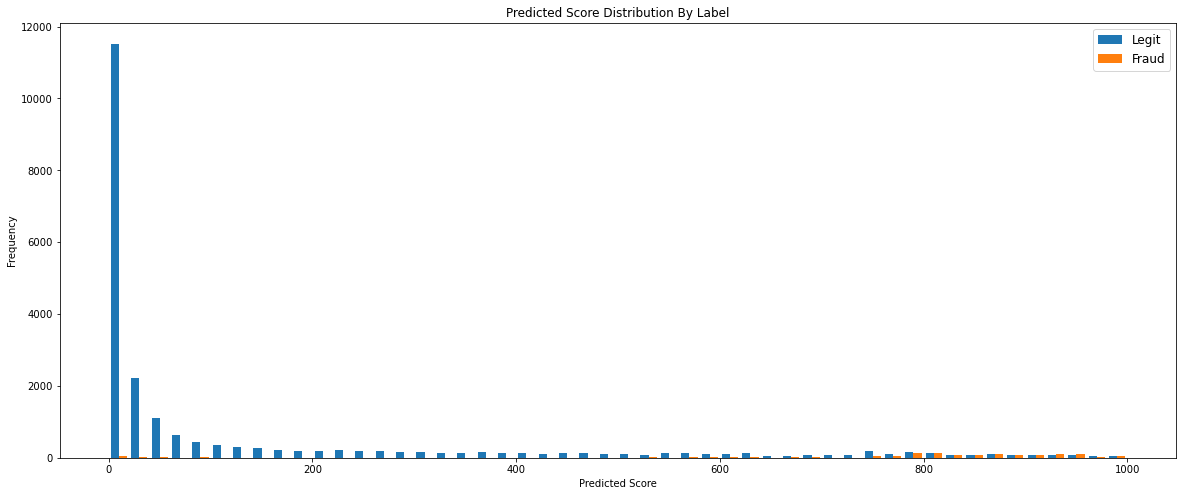

In [22]:
# -- check the distribution by labels --
plt.figure(figsize = (20,8))
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.hist([predictions[predictions[VARIABLES_MAP['EVENT_LABEL']].isin(label_mapper['LEGIT'])]['score'], 
          predictions[predictions[VARIABLES_MAP['EVENT_LABEL']].isin(label_mapper['FRAUD'])]['score']], bins = 50)
plt.legend(["Legit", "Fraud"], fontsize=12)
plt.title("Predicted Score Distribution By Label")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.show()

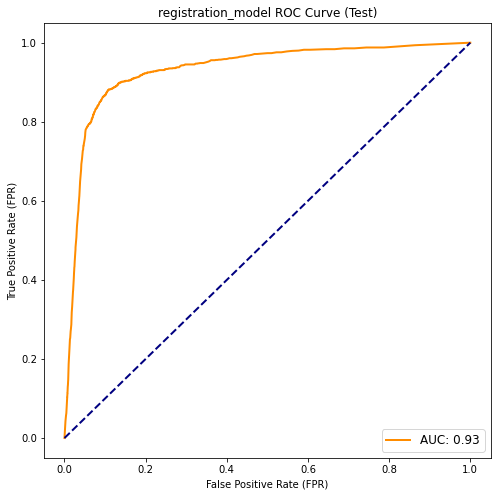

In [23]:
# -- check AUC --
predictions['event_label_int'] = np.nan
predictions.loc[predictions[VARIABLES_MAP['EVENT_LABEL']].isin(label_mapper['LEGIT']), 'event_label_int'] = 0
predictions.loc[predictions[VARIABLES_MAP['EVENT_LABEL']].isin(label_mapper['FRAUD']), 'event_label_int'] = 1
                
fpr, tpr, threshold = roc_curve(predictions['event_label_int'], predictions['score'])
test_auc = auc(fpr,tpr)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC: {test_auc:.2f}") 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title(MODEL_NAME+" ROC Curve (Test)")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend(loc="lower right", fontsize=12)
plt.show()

### (Optional) Write Predictions to File

<div class="alert alert-info"> 💡<strong> Write Predictions </strong>

- You can write your prediction dataset to a CSV to manually review predictions
- Simply add a cell below and copy the code below

</div>



```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(MODEL_NAME + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(MODEL_NAME + ".xlsx", index=False)

```

In [24]:
# #restore original boto3 version
# %pip install 'boto3=={}'.format(original_boto3_version)